<a href="https://colab.research.google.com/github/SanjayBhargavKudupudi/DATA_MINING/blob/main/timeseries/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
Path = "/content/drive/MyDrive/shopping_time_series_dataset.csv"


# Load the dataset

data = pd.read_csv(Path)

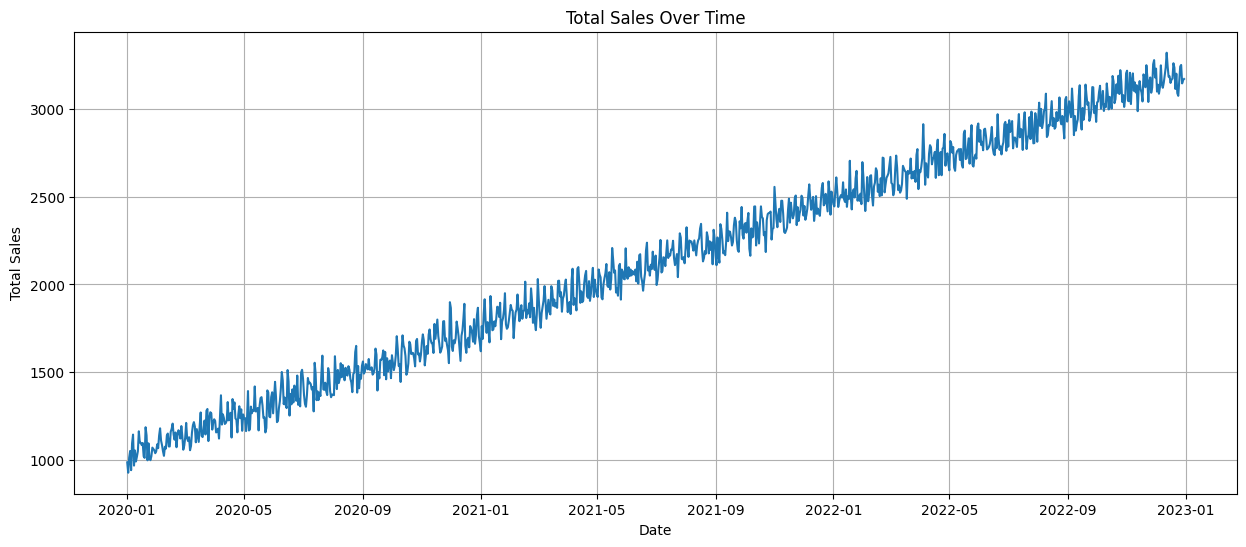

((Timestamp('2020-01-01 00:00:00'), Timestamp('2022-12-30 00:00:00')),
 Date           datetime64[ns]
 Total_Sales           float64
 dtype: object,
 count    1095.000000
 mean     2120.423756
 std       638.411551
 min       926.604425
 25%      1564.956093
 50%      2117.101235
 75%      2666.054579
 max      3320.809140
 Name: Total_Sales, dtype: float64,
 Date           0
 Total_Sales    0
 dtype: int64)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Date' to datetime and sort the data
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Checking the range of dates and data types
date_range = data['Date'].min(), data['Date'].max()
data_types = data.dtypes

# Statistical summary of 'Total_Sales'
stat_summary = data['Total_Sales'].describe()

# Check for missing values
missing_values = data.isnull().sum()

# Plotting Total Sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=data['Date'], y=data['Total_Sales'])
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

date_range, data_types, stat_summary, missing_values


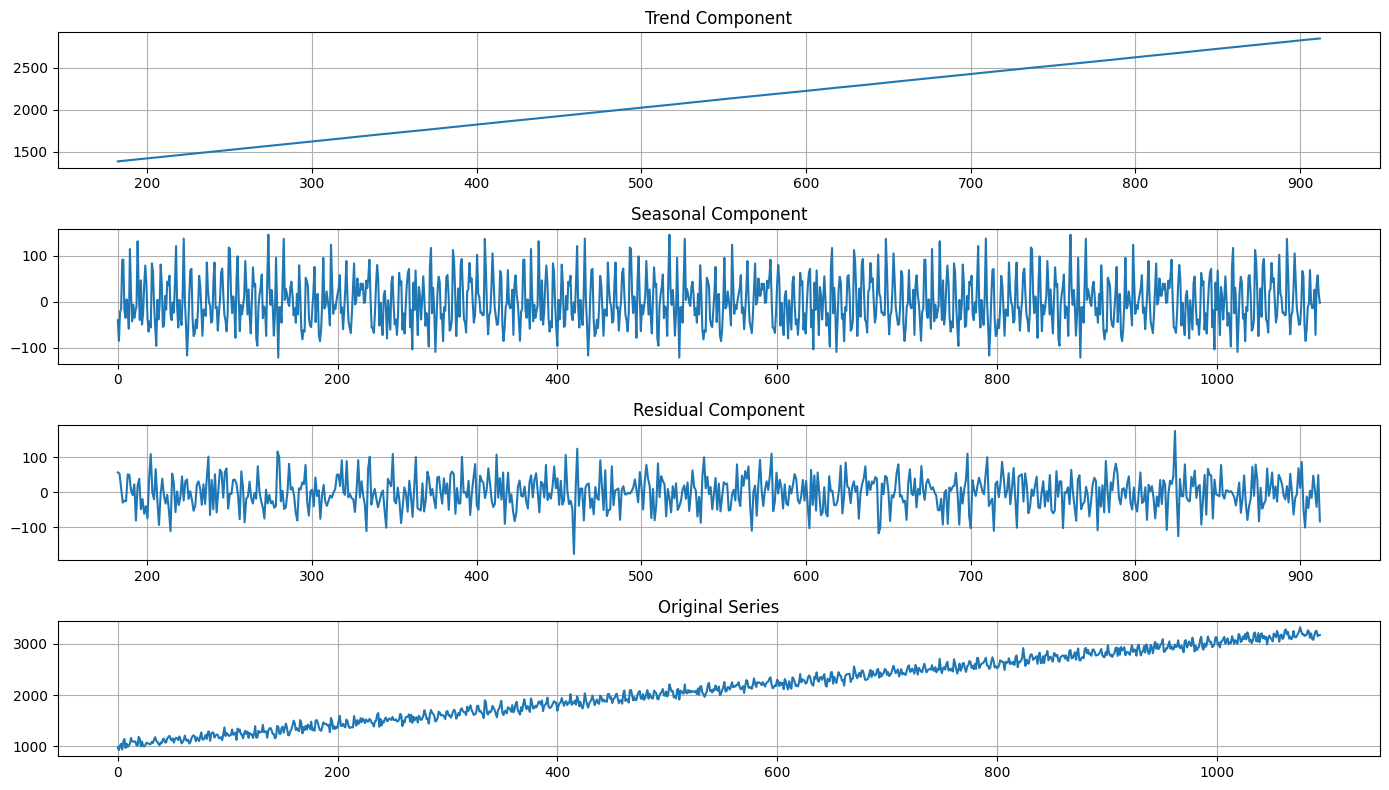

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decomposition = seasonal_decompose(data['Total_Sales'], model='additive', period=365)

# Plotting the decomposed time series components
plt.figure(figsize=(14, 8))

# Trend component
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend Component')
plt.grid(True)

# Seasonal component
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')
plt.grid(True)

# Residual component
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residual Component')
plt.grid(True)

# Original Series
plt.subplot(414)
plt.plot(data['Total_Sales'])
plt.title('Original Series')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Performing the Augmented Dickey-Fuller test
adf_test = adfuller(data['Total_Sales'])

# Extracting the p-value
adf_p_value = adf_test[1]

adf_p_value


0.9392709375526979

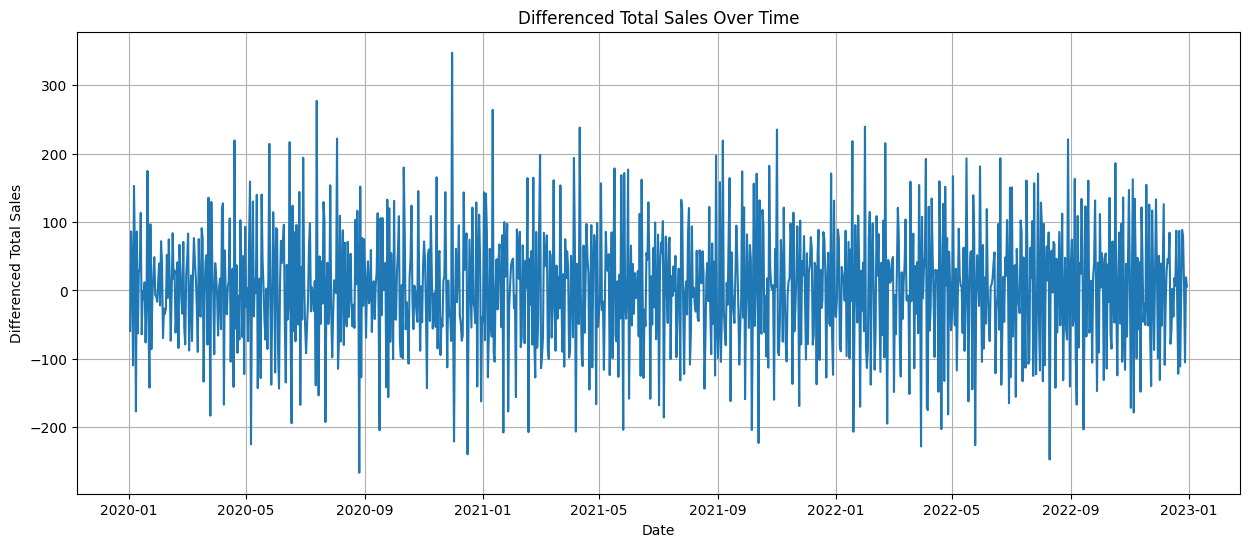

9.238968968635465e-26

In [ ]:
# Differencing the series
data['Sales_Diff'] = data['Total_Sales'].diff()

# Dropping the first NaN value after differencing
data_diff = data.dropna()

# Performing the Augmented Dickey-Fuller test again on the differenced series
adf_test_diff = adfuller(data_diff['Sales_Diff'])

# Extracting the p-value
adf_p_value_diff = adf_test_diff[1]

# Plotting the differenced series
plt.figure(figsize=(15, 6))
sns.lineplot(x=data_diff['Date'], y=data_diff['Sales_Diff'])
plt.title('Differenced Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Total Sales')
plt.grid(True)
plt.show()

adf_p_value_diff


In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature Engineering
# Adding day of the week and month as features
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month

# Adding rolling averages
data['Rolling_Mean_7'] = data['Total_Sales'].rolling(window=7).mean()
data['Rolling_Mean_30'] = data['Total_Sales'].rolling(window=30).mean()

# Filling any NaN values created by rolling means with the original sales values
data['Rolling_Mean_7'].fillna(data['Total_Sales'], inplace=True)
data['Rolling_Mean_30'].fillna(data['Total_Sales'], inplace=True)

# Standardizing the features (important for K-Means)
scaler = StandardScaler()
features = ['Total_Sales', 'Rolling_Mean_7', 'Rolling_Mean_30', 'Day_of_Week', 'Month']
data_scaled = scaler.fit_transform(data[features])

data_scaled[:5]  # Displaying first 5 rows of scaled features for review


array([[-1.77816835, -1.77785161, -1.7460082 , -0.50057176, -1.6006851 ],
       [-1.87083837, -1.87099226, -1.83931171,  0.        , -1.6006851 ],
       [-1.73563159, -1.73509882, -1.70318066,  0.50057176, -1.6006851 ],
       [-1.67656963, -1.67573691, -1.64371495,  1.00114351, -1.6006851 ],
       [-1.848118  , -1.8481565 , -1.81643603,  1.50171527, -1.6006851 ]])

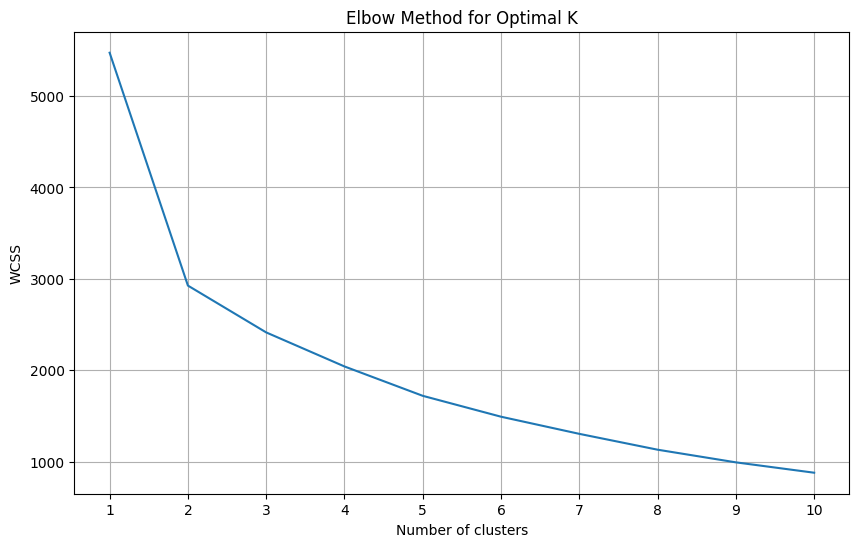

In [ ]:
from sklearn.cluster import KMeans

# Determining the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [ ]:
# Clustering with K-Means
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(data_scaled)

# Adding the cluster labels to the original dataframe
data['Cluster'] = clusters

# Anomaly Detection using Z-score
from scipy.stats import zscore

# Calculating the Z-score for the Total_Sales column
data['Z_Score'] = zscore(data['Total_Sales'])

# Defining a threshold for anomalies (e.g., 3 standard deviations)
threshold = 3
anomalies = data[abs(data['Z_Score']) > threshold]

# Displaying some of the clustered data and anomalies
clustered_data_head = data.head()
anomalies_head = anomalies.head()

clustered_data_head, anomalies_head


(        Date  Total_Sales  Sales_Diff  Day_of_Week  Month  Rolling_Mean_7  \
 0 2020-01-01   985.739019         NaN            2      1      985.739019   
 1 2020-01-02   926.604425  -59.134593            3      1      926.604425   
 2 2020-01-03  1012.882573   86.278147            4      1     1012.882573   
 3 2020-01-04  1050.571193   37.688620            5      1     1050.571193   
 4 2020-01-05   941.102746 -109.468447            6      1      941.102746   
 
    Rolling_Mean_30  Cluster   Z_Score  
 0       985.739019        3 -1.778168  
 1       926.604425        3 -1.870838  
 2      1012.882573        3 -1.735632  
 3      1050.571193        3 -1.676570  
 4       941.102746        3 -1.848118  ,
 Empty DataFrame
 Columns: [Date, Total_Sales, Sales_Diff, Day_of_Week, Month, Rolling_Mean_7, Rolling_Mean_30, Cluster, Z_Score]
 Index: [])

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import zscore

# Reload the dataset as the session was reset
file_path = '/content/drive/MyDrive/shopping_time_series_dataset.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Feature Engineering
# Adding day of the week and month as features
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month

# Adding rolling averages
data['Rolling_Mean_7'] = data['Total_Sales'].rolling(window=7).mean()
data['Rolling_Mean_30'] = data['Total_Sales'].rolling(window=30).mean()

# Filling any NaN values created by rolling means with the original sales values
data['Rolling_Mean_7'].fillna(data['Total_Sales'], inplace=True)
data['Rolling_Mean_30'].fillna(data['Total_Sales'], inplace=True)

# Standardizing the features
scaler = StandardScaler()
features = ['Total_Sales', 'Rolling_Mean_7', 'Rolling_Mean_30', 'Day_of_Week', 'Month']
data_scaled = scaler.fit_transform(data[features])

# Clustering with K-Means
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(data_scaled)

# Adding the cluster labels to the original dataframe
data['Cluster'] = clusters

# Anomaly Detection using Z-score
# Calculating the Z-score for the Total_Sales column
data['Z_Score'] = zscore(data['Total_Sales'])

# Defining a threshold for anomalies (e.g., 3 standard deviations)
threshold = 3
anomalies = data[abs(data['Z_Score']) > threshold]

# Displaying some of the clustered data and anomalies
clustered_data_head = data.head()
anomalies_head = anomalies.head()

clustered_data_head, anomalies_head


(        Date  Total_Sales  Day_of_Week  Month  Rolling_Mean_7  \
 0 2020-01-01   985.739019            2      1      985.739019   
 1 2020-01-02   926.604425            3      1      926.604425   
 2 2020-01-03  1012.882573            4      1     1012.882573   
 3 2020-01-04  1050.571193            5      1     1050.571193   
 4 2020-01-05   941.102746            6      1      941.102746   
 
    Rolling_Mean_30  Cluster   Z_Score  
 0       985.739019        3 -1.778168  
 1       926.604425        3 -1.870838  
 2      1012.882573        3 -1.735632  
 3      1050.571193        3 -1.676570  
 4       941.102746        3 -1.848118  ,
 Empty DataFrame
 Columns: [Date, Total_Sales, Day_of_Week, Month, Rolling_Mean_7, Rolling_Mean_30, Cluster, Z_Score]
 Index: [])

In [ ]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Load data
data = h2o.import_file('/content/drive/MyDrive/shopping_time_series_dataset.csv')

# Preprocess data (e.g., feature engineering)
# ...

# Splitting the data
train, test = data.split_frame(ratios=[.8])

# Identify predictors and response
x = train.columns
y = "Total_Sales"
x.remove(y)

# For classification, ensure the target column is a factor
# train[y] = train[y].asfactor()

# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows

# Predict on test data
preds = aml.leader.predict(test)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 38 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_m1knf2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
